### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os

### Load matlab file

In [2]:
# loadmat aux function to load the matlab save files
# from: https://stackoverflow.com/review/suggested-edits/21667510

import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _has_struct(elem):
        """Determine if elem is an array and if any array item is a struct"""
        return isinstance(elem, np.ndarray) and any(isinstance(
                    e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif _has_struct(elem):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif _has_struct(sub_elem):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [3]:
# Matlab code conversion

# Read matlab file instead of excelfile (easier conversion)
data = loadmat('../matlab.mat')

### Import Procsim

In [4]:
import procsimulator

from procsimulator.CommunityGenerator import CommunityGenerator
from procsimulator.ConsumptionGenerator import ConsumptionGenerator

from procsimulator.DataFromSmile import DataFromSmile
from procsimulator.DataFromTomorrow import DataFromTomorrow
from procsimulator.RenewableEnergyGenerator import RenewableEnergyGenerator
from procsimulator.CommunityGenerator import CommunityGenerator

### Get community data (consumption, PV production, wind production, total production and netload)

In [5]:
current_path = os.getcwd()
path_steps_seconds = os.path.join(current_path, "..")
path_steps_minutes = "../output/minute"

pv_df = pd.read_csv(path_steps_minutes + '/netload.csv', sep=';')
pv_df.columns = ['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production', 'Netload']
pv_df['Date'] = pd.to_datetime(pv_df['Date'])
print(pv_df)

                    Date       Demand  PV_Production  Wind_Production  \
0    2022-10-12 00:00:00  1364.146667            0.0      2990.000000   
1    2022-10-12 00:01:00  1363.206667            0.0      2990.027616   
2    2022-10-12 00:02:00  1340.268333            0.0      2989.972909   
3    2022-10-12 00:03:00  1455.428333            0.0      2989.836683   
4    2022-10-12 00:04:00  1466.303333            0.0      2989.619742   
...                  ...          ...            ...              ...   
1434 2022-10-12 23:54:00  3374.000000            0.0      1589.130212   
1435 2022-10-12 23:55:00  3515.371667            0.0      1588.667798   
1436 2022-10-12 23:56:00  3363.616667            0.0      1588.272937   
1437 2022-10-12 23:57:00  2994.000000            0.0      1587.947020   
1438 2022-10-12 23:58:00  2529.200000            0.0      1587.691435   

       Production      Netload  
0     2990.000000 -1625.853333  
1     2990.027616 -1626.820949  
2     2989.972909 -1649.

### Downsample data to 1 hour

In [6]:
pv_df = pv_df.resample('1H', on='Date').mean()
pv_df = pv_df.reset_index()
print(pv_df)

                  Date       Demand  PV_Production  Wind_Production  \
0  2022-10-12 00:00:00  1156.662000       0.000000      2950.396353   
1  2022-10-12 01:00:00  1044.179611       0.000000      2757.618891   
2  2022-10-12 02:00:00  1090.567944       0.000000      2511.437921   
3  2022-10-12 03:00:00  3428.161222       0.000000      2234.999886   
4  2022-10-12 04:00:00  2853.616139       0.000000      1933.498250   
5  2022-10-12 05:00:00  2923.541167       0.000000      1816.794244   
6  2022-10-12 06:00:00  1964.824667       0.000000      1940.630224   
7  2022-10-12 07:00:00  2047.357806      44.877653      2072.547807   
8  2022-10-12 08:00:00  3383.390361     705.942591      2118.502209   
9  2022-10-12 09:00:00  2039.494000    1411.218676      2145.167175   
10 2022-10-12 10:00:00  2421.842722    2616.814701      2088.878414   
11 2022-10-12 11:00:00  3082.200722    3893.046327      2006.330712   
12 2022-10-12 12:00:00  2357.677444    5283.392703      2079.687762   
13 202

### Plot Wind Production

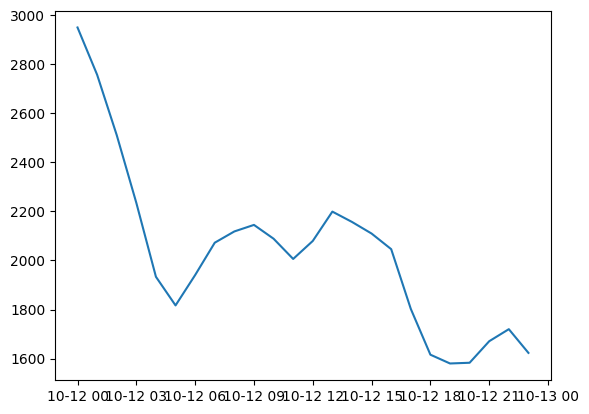

In [7]:
plt.plot(pv_df["Date"], pv_df["Wind_Production"])
plt.show()

### Plot PV Production

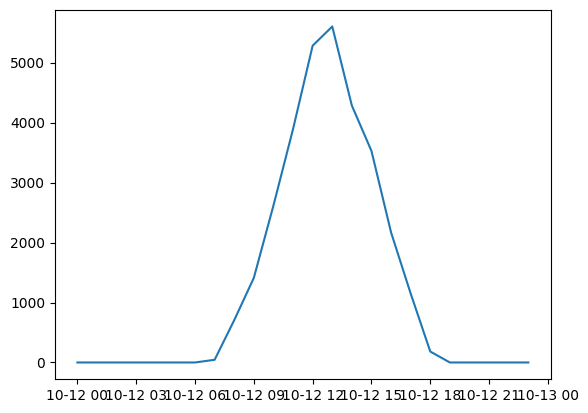

In [8]:
plt.plot(pv_df["Date"], pv_df["PV_Production"])
plt.show()

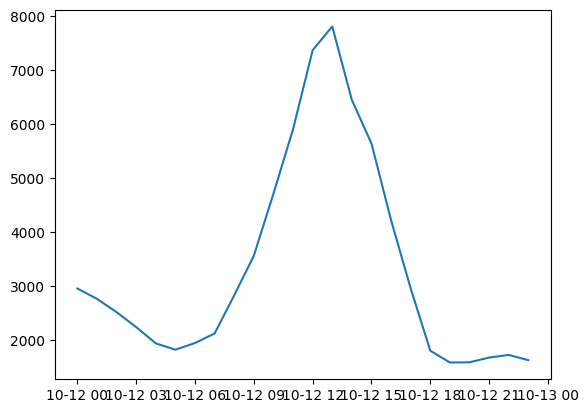

In [9]:
plt.plot(pv_df["Date"], pv_df["Production"])
plt.show()

### Change Consumption data in order to be used in the optimization model

In [10]:
cg = ConsumptionGenerator("../data.json", path_steps_seconds, path_steps_minutes)
community_size = len(cg.get_community())
num_generators = 2

data['data']['parameterData']['resources']['numGen'] = num_generators
data['data']['parameterData']['resources']['numLoad'] = community_size

data['data']['load']['limit'] = data['data']['load']['limit'][:community_size]
data['data']['load']['info'] = data['data']['load']['info'][:community_size]

data['data']['generator']['limit'] = data['data']['generator']['limit'][:num_generators]
data['data']['generator']['info'] = data['data']['generator']['info'][:num_generators]

for x in os.walk(path_steps_minutes):
    if x[0] is not path_steps_minutes:
        print(x[0])
        house_total_df = pd.read_csv(x[0] + '/total.csv', sep=';')
        house_total_df.columns = ['Date', 'Demand']
        house_total_df['Date'] = pd.to_datetime(house_total_df['Date'])
        house_total_df.set_index('Date')
        
        house_total_df = house_total_df.resample('1H', on='Date').mean()
                
        pos = int(x[0].split("house")[1])
        for y in range(len(data['data']['load']['limit'][pos])):
            data['data']['load']['limit'][pos][y][0] = house_total_df.iloc[y]["Demand"]/1000
            data['data']['load']['limit'][pos][y][1] = 0
            data['data']['load']['limit'][pos][y][2] = house_total_df.iloc[y]["Demand"]/1000*0.01
            data['data']['load']['limit'][pos][y][3] = house_total_df.iloc[y]["Demand"]/1000*0.01
            print(house_total_df.iloc[y]["Demand"])

../output/minute\house0
134.91030555555557
134.91030555555557
166.8206111111111
134.91030555555554
134.91030555555554
147.25180555555556
122.56880555555556
183.6151388888889
1217.2666111111112
458.7318888888889
762.1120555555555
305.22825
194.26433333333335
191.7443888888889
177.00383333333332
194.54669444444443
184.43408333333335
375.58680555555554
214.52877777777778
182.9657777777778
602.5773888888889
219.0569722222222
169.78594444444443
187.98683333333335
../output/minute\house1
166.8206111111111
134.91030555555557
134.91030555555554
129.33927777777777
140.4813333333333
125.16116666666667
144.65944444444446
134.91030555555554
134.91030555555554
343.98377777777773
224.97488888888887
233.20716666666667
189.42719444444444
178.16777777777776
417.31736111111115
433.6670833333334
191.96602777777778
195.74919444444447
166.47741666666667
206.64791666666667
767.9088333333333
1186.861
631.0052499999999
264.11777777777775
../output/minute\house2
212.67627777777778
193.5473888888889
203.1118333

### Change generator type to 2 (Renewables) in the second generator

In [11]:
data['data']['generator']['info'][1][1] = 2

### Change Production (Wind and PV) data in order to be used in the optimization model

In [12]:
#Add Production (Generator with type = 2 - Renewables)
for x in range(len(data['data']['generator']['limit'])):
    for y in range(len(data['data']['generator']['limit'][x])):
        if (x == 0): #PV
            data['data']['generator']['limit'][x][y][0] = pv_df.iloc[y]["PV_Production"]/1000
        else: #Wind
            data['data']['generator']['limit'][x][y][0] = pv_df.iloc[y]["Wind_Production"]/1000


### Linearize the generator prices

In [13]:
genCofA = data['data']['generator']['limit'][:, :, 5]
genCofB = data['data']['generator']['limit'][:, :, 6]
genCofC = data['data']['generator']['limit'][:, :, 7]

### Options for simulation

In [14]:
iterlim = 1000000000
reslim = 5000000000

### Define the number of the used resources (generators, houses, periods, etc)

In [15]:
numGen = np.arange(1, data['data']['parameterData']['resources']['numGen'] + 1)
numLoad = np.arange(1, data['data']['parameterData']['resources']['numLoad'] + 1)
numPeriod = np.arange(1, data['data']['parameterData']['resources']['period'] + 1)
numBus = np.arange(1) # forced to 1
nOwner = np.arange(1, data['data']['parameterData']['resources']['owners'] + 1)

### Define the strings with the resources in order to be used by GAMS

In [16]:
gen = np.max(numGen)
Load = np.max(numLoad)
period = np.max(numPeriod)
Bus = np.max(numBus)

### Define the matrixes with the data in order to be used by GAMS

In [17]:
# General Info
pMaxImp = data['data']['parameterData']['generalInfo']['P_Max_Imp']
pMaxExp = data['data']['parameterData']['generalInfo']['P_Max_Exp']
buyPrice = data['data']['parameterData']['generalInfo']['Energy_Buy_Price']
sellPrice = data['data']['parameterData']['generalInfo']['Energy_Sell_Price']

# Generatores
genLimit = data['data']['generator']['limit'][numGen[0]-1:numGen[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
genInfo = data['data']['generator']['info']

# Loads
loadLimit = data['data']['load']['limit'][numLoad[0]-1:numLoad[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]

### Define the network data for the GAMS

In [18]:
# Branchs
branchData = data['data']['network']['branch']

# Maximum Voltage
voltageMax = data['data']['parameterData']['network']['voltageMax']

# Minimum Voltage
voltageMin = data['data']['parameterData']['network']['voltageMin']

# Maximum Angle
angleMax = data['data']['parameterData']['network']['angleMax']

# Minimum Angle
angleMin = data['data']['parameterData']['network']['angleMin']

# Defines the matrix of admitances
ybus = data['data']['parameterData']['network']['ybus']
diag = data['data']['parameterData']['network']['diag']
branchID = data['data']['parameterData']['network']['branch']

### Reset the DG fixed and quadratic cost

In [19]:
genLimit[:, :, 3] = 0
genLimit[:, :, 5] = 0

genLimit = np.append(genLimit, np.zeros(shape=(num_generators, 24, 4)), axis=2)

### Define the fixed sets structure to use in the parameters of the gams optimization process

In [20]:
NCOLS = 12

genLimitInfo = np.arange(1, NCOLS+1)
loadLimitInfo = np.arange(1, NCOLS+1)


### Define the several sets structure used in the gams optimization process

In [21]:
# these sets depends the number of resources used in matlab code

_t = np.arange(1, period+1)
_gen = np.arange(1, gen+1)
_Load = np.arange(1, Load+1)

### Aux function to convert numpy into dictionaries

In [22]:
def _auxDictionary(a):
    temp_dictionary = {}
    
    if len(a.shape) == 3:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                for dim2 in np.arange(a.shape[2]):
                    temp_dictionary[(dim0+1, dim1+1, dim2+1)] = a[dim0, dim1, dim2]
    elif len(a.shape) == 2:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                temp_dictionary[(dim0+1, dim1+1)] = a[dim0, dim1]
                
    else:
        for dim0 in np.arange(a.shape[0]):
            temp_dictionary[(dim0+1)] = a[dim0]
                
    return temp_dictionary

#temp_dict1 = _auxDictionary(loadLimit)

### Pyomo Imports

In [23]:
import pyomo
import pyomo.opt
import pyomo.environ as pe

### Create the model

In [24]:
model = pe.ConcreteModel()

model.genLimitInfo = pe.Set(initialize=genLimitInfo, 
                            doc='Indicate the number of columns of information from generators')
model.loadLimitInfo = pe.Set(initialize=loadLimitInfo, 
                             doc='Indicate the number of columns of information from loads')

# Sets
model.t = pe.Set(initialize=_t, doc='period')
model.gen = pe.Set(initialize=_gen, doc='generators')
model.loads = pe.Set(initialize=_Load, doc='loads')

### Define the parameters with the data from the excel, such as limits, price, and voltage

In [25]:
model.loadLimit = pe.Param(model.loads, model.t, model.loadLimitInfo, 
                           initialize=_auxDictionary(loadLimit))

model.genLimit = pe.Param(model.gen, model.t, model.genLimitInfo,
                          initialize=_auxDictionary(genLimit))

model.genInfo = pe.Param(model.gen, model.genLimitInfo,
                         initialize=_auxDictionary(genInfo))

model.pMaxImp = pe.Param(model.t,
                         initialize=_auxDictionary(pMaxImp))

model.buyPrice = pe.Param(model.t,
                          initialize=_auxDictionary(buyPrice))

model.pMaxExp = pe.Param(model.t,
                         initialize=_auxDictionary(pMaxExp))

model.sellPrice = pe.Param(model.t,
                           initialize=_auxDictionary(sellPrice))

model.loadActPower = pe.Param(model.loads, model.t,
                              initialize=_auxDictionary(loadLimit[:, :, 0]))
model.optCost = pe.Var()#initialize=0)

### Define the variables for the gams optimization process

In [26]:
model.derCost = pe.Var(domain=pe.Reals, initialize=0)

In [27]:
# Positive variables
model.genActPower = pe.Var(model.gen, model.t, domain=pe.PositiveReals, initialize=1)
model.genExcActPower = pe.Var(model.gen, model.t, domain=pe.PositiveReals, initialize=1)
model.pImp = pe.Var(model.t, domain=pe.PositiveReals, initialize=1)
model.pExp = pe.Var(model.t, domain=pe.PositiveReals, initialize=1)

In [28]:
# Load params
model.loadRedActPower = pe.Var(model.loads, model.t, domain=pe.PositiveReals, initialize=1)
model.loadCutActPower = pe.Var(model.loads, model.t, domain=pe.PositiveReals, initialize=1)
model.loadENS = pe.Var(model.loads, model.t, domain=pe.PositiveReals, initialize=1)

In [29]:
# Binary variables
model.genXo = pe.Var(model.gen, model.t, domain=pe.Binary, initialize=0)
model.loadXo = pe.Var(model.loads, model.t, domain=pe.Binary, initialize=0)

In [30]:
# Default behaviour
default_behaviour = pe.Constraint.Skip

### Define the Model Constraints

In [31]:
# Network constraints

def _maxImpEq(m, t):
    return m.pImp[t] <= m.pMaxImp[t] 

model.MaxImpEq = pe.Constraint(model.t, rule=_maxImpEq)

def _maxExpEq(m, t):
    return m.pExp[t] <= m.pMaxExp[t]

model.MaxExpEq = pe.Constraint(model.t, rule=_maxExpEq)

In [32]:
# Generator constraints with the active generation power

# Maximum generation in generators with normal contract
def _genActMaxEq1(m, g, t):
    if m.genInfo[g, 5] == 1:
        return (m.genActPower[g, t] <= m.genLimit[g, t, 1])
    return default_behaviour
    
model.genActMaxEq1 = pe.Constraint(model.gen, model.t, rule=_genActMaxEq1)

#*Minimum generation in generators with normal contract
def _genActMinEq(m, g, t):
    if m.genInfo[g, 5] == 1:
        return (m.genActPower[g, t] >= m.genInfo[g, 7] * m.genXo[g, t])
    return default_behaviour
    
model.genActMinEq = pe.Constraint(model.gen, model.t, rule=_genActMinEq)

#*Generation in generators with Feed-in tariffs
def _genActMaxEq2(m, g, t):
    if m.genInfo[g, 5] == 2:
        return (m.genActPower[g ,t] + m.genExcActPower[g, t] == m.genLimit[g, t, 1])
    return default_behaviour
    
model.genActMaxEq2 = pe.Constraint(model.gen, model.t, rule=_genActMaxEq2)

In [33]:
# Load constraints

def _loadReactEq(m, l, t):
    return m.loadRedActPower[l, t] <= m.loadLimit[l, t, 3]

model.loadReactEq = pe.Constraint(model.loads, model.t, rule=_loadReactEq)


def _loadCutActPowerEq(m, l, t):
    return m.loadCutActPower[l, t] == m.loadLimit[l, t, 4] * m.loadXo[l, t]

model.loadCutActPowerEq = pe.Constraint(model.loads, model.t, rule=_loadCutActPowerEq)


def _loadENSEq(m, l, t):
    return m.loadENS[l, t] + m.loadRedActPower[l, t] + m.loadCutActPower[l, t] <= m.loadActPower[l, t]

model.loadENSEq = pe.Constraint(model.loads, model.t, rule=_loadENSEq)

In [34]:
# Energy Balance

def _actBalanceEqSimple(m, t):
    temp_sum1 = sum([m.genActPower[i, t] - m.genExcActPower[i, t] for i in np.arange(1, m.gen.last()+1)])
    temp_sum2 = sum(m.loadActPower[:, t])
    
    return temp_sum1 + m.pImp[t] - m.pExp[t] - temp_sum2 == 0

#model.actBalanceSimple = pe.Constraint(model.t, rule=_actBalanceEqSimple)


def _actBalanceEq(m, t):
    temp_gens = sum([m.genActPower[g, t] - m.genExcActPower[g, t] for g in np.arange(1, m.gen.last()+1)])
    
    temp_loads = sum([m.loadActPower[l, t] - m.loadRedActPower[l, t] - m.loadCutActPower[l, t] - m.loadENS[l, t]
                      for l in np.arange(1, m.loads.last() + 1)])
    
    return temp_gens + m.pImp[t] - m.pExp[t] - temp_loads == 0
model.actBalanceSimple = pe.Constraint(model.t, rule=_actBalanceEq)

# Define the Objective Function

In [35]:
def _objFun(m):
    temp_gens = sum([m.genActPower[g, t] * m.genLimit[g, t, 3] + m.genExcActPower[g, t] * m.genLimit[g, t, 5]
                     for t in np.arange(1, m.t.last() + 1) for g in np.arange(1, m.gen.last()+1)])
    
    temp_loads = sum([m.loadRedActPower[l, t] * m.loadLimit[l, t, 7] + m.loadCutActPower[l, t] * m.loadLimit[l, t, 8] + m.loadENS[l, t] * m.loadLimit[l, t, 10] 
                      for t in np.arange(1, m.t.last() + 1) for l in np.arange(1, m.loads.last() + 1)])
    
    temp_rest = sum([m.pImp[t] * m.buyPrice[t] - m.pExp[t] * m.sellPrice[t] for t in np.arange(1, m.t.last() + 1)])

    m.derCost = temp_gens + temp_loads + temp_rest
    
    return temp_gens + temp_loads + temp_rest

model.ObjFun = pe.Objective(rule=_objFun, sense=pe.minimize)

### Solve the model using Ipopt or Cplex

In [36]:
import cplex
from pyomo.opt import SolverFactory

model.write('res_V4_EC.lp',  io_options={'symbolic_solver_labels': True})

# Create a solver
#opt = pe.SolverFactory('cplex', executable='C:/Program Files/IBM/ILOG/CPLEX_Studio_Community221/cplex/bin/x64_win64/cplex.exe')
opt = pe.SolverFactory('ipopt', executable='C:/Program Files/Ipopt-3.11.1-win64-intel13.1/bin/ipopt.exe')
#opt.options['LogFile'] = 'res_V4_EC.log'
opt.options['print_level'] = 12
opt.options['output_file'] = "res_V5_EC.log"

results = opt.solve(model)#, tee=True)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 504
  Number of variables: 624
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 5.090292930603027
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


### Extract Pyomo values

In [37]:
# Extract Pyomo values
# https://stackoverflow.com/questions/67491499/how-to-extract-indexed-variable-information-in-pyomo-model-and-build-pandas-data

def ext_pyomo_vals(vals):
    # make a pd.Series from each 
    s = pd.Series(vals.extract_values(),
                  index=vals.extract_values().keys())
    
    # if the series is multi-indexed we need to unstack it...
    if type(s.index[0]) == tuple:    # it is multi-indexed
        s = s.unstack(level=1)
    else:
        # force transition from Series -> df
        s = pd.DataFrame(s)
        
    return s

### Extract the results

In [38]:
# Generation
result_genActPower = ext_pyomo_vals(model.genActPower)
result_genExcActPower = ext_pyomo_vals(model.genExcActPower)

# Imports/Exports
result_pimp = ext_pyomo_vals(model.pImp)
result_pexp = ext_pyomo_vals(model.pExp)

# Loads
result_loadRedActPower = ext_pyomo_vals(model.loadRedActPower)
result_loadCutActPower = ext_pyomo_vals(model.loadCutActPower)
result_loadENS = ext_pyomo_vals(model.loadENS)

# Booleans
result_genXo = ext_pyomo_vals(model.genXo)
result_loadXo = ext_pyomo_vals(model.loadXo)

### Convert the results to pandas csv and save the results

In [39]:
# Gens
pd_genActPower = pd.DataFrame(result_genActPower)
pd_genActPower.to_csv('../results/cplex_pyomo/genActPower.csv', index=None)

pd_genExcActPower = pd.DataFrame(result_genExcActPower)
pd_genExcActPower.to_csv('../results/cplex_pyomo/genExcActPower.csv', index=None)

# Import/Export
pd_pimp = pd.DataFrame(result_pimp)
pd_pimp.to_csv('../results/cplex_pyomo/pimp.csv', index=None)

pd_pexp = pd.DataFrame(result_pexp)
pd_pexp.to_csv('../results/cplex_pyomo/pexp.csv', index=None)

# Loads
pd_loadRedActPower = pd.DataFrame(result_loadRedActPower)
pd_loadRedActPower.to_csv('../results/cplex_pyomo/loadRedActPower.csv', index=None)

pd_loadCutActPower = pd.DataFrame(result_loadCutActPower)
pd_loadCutActPower.to_csv('../results/cplex_pyomo/loadCutActPower.csv', index=None)

pd_loadENS = pd.DataFrame(result_loadENS)
pd_loadENS.to_csv('../results/cplex_pyomo/loadENS.csv', index=None)


# Booleans
pd_genXo = pd.DataFrame(result_genXo)
pd_genXo.to_csv('../results/cplex_pyomo/genXo.csv', index=None)

pd_loadXo = pd.DataFrame(result_loadXo)
pd_loadXo.to_csv('../results/cplex_pyomo/loadXo.csv', index=None)

### Plot the results of the optimization model

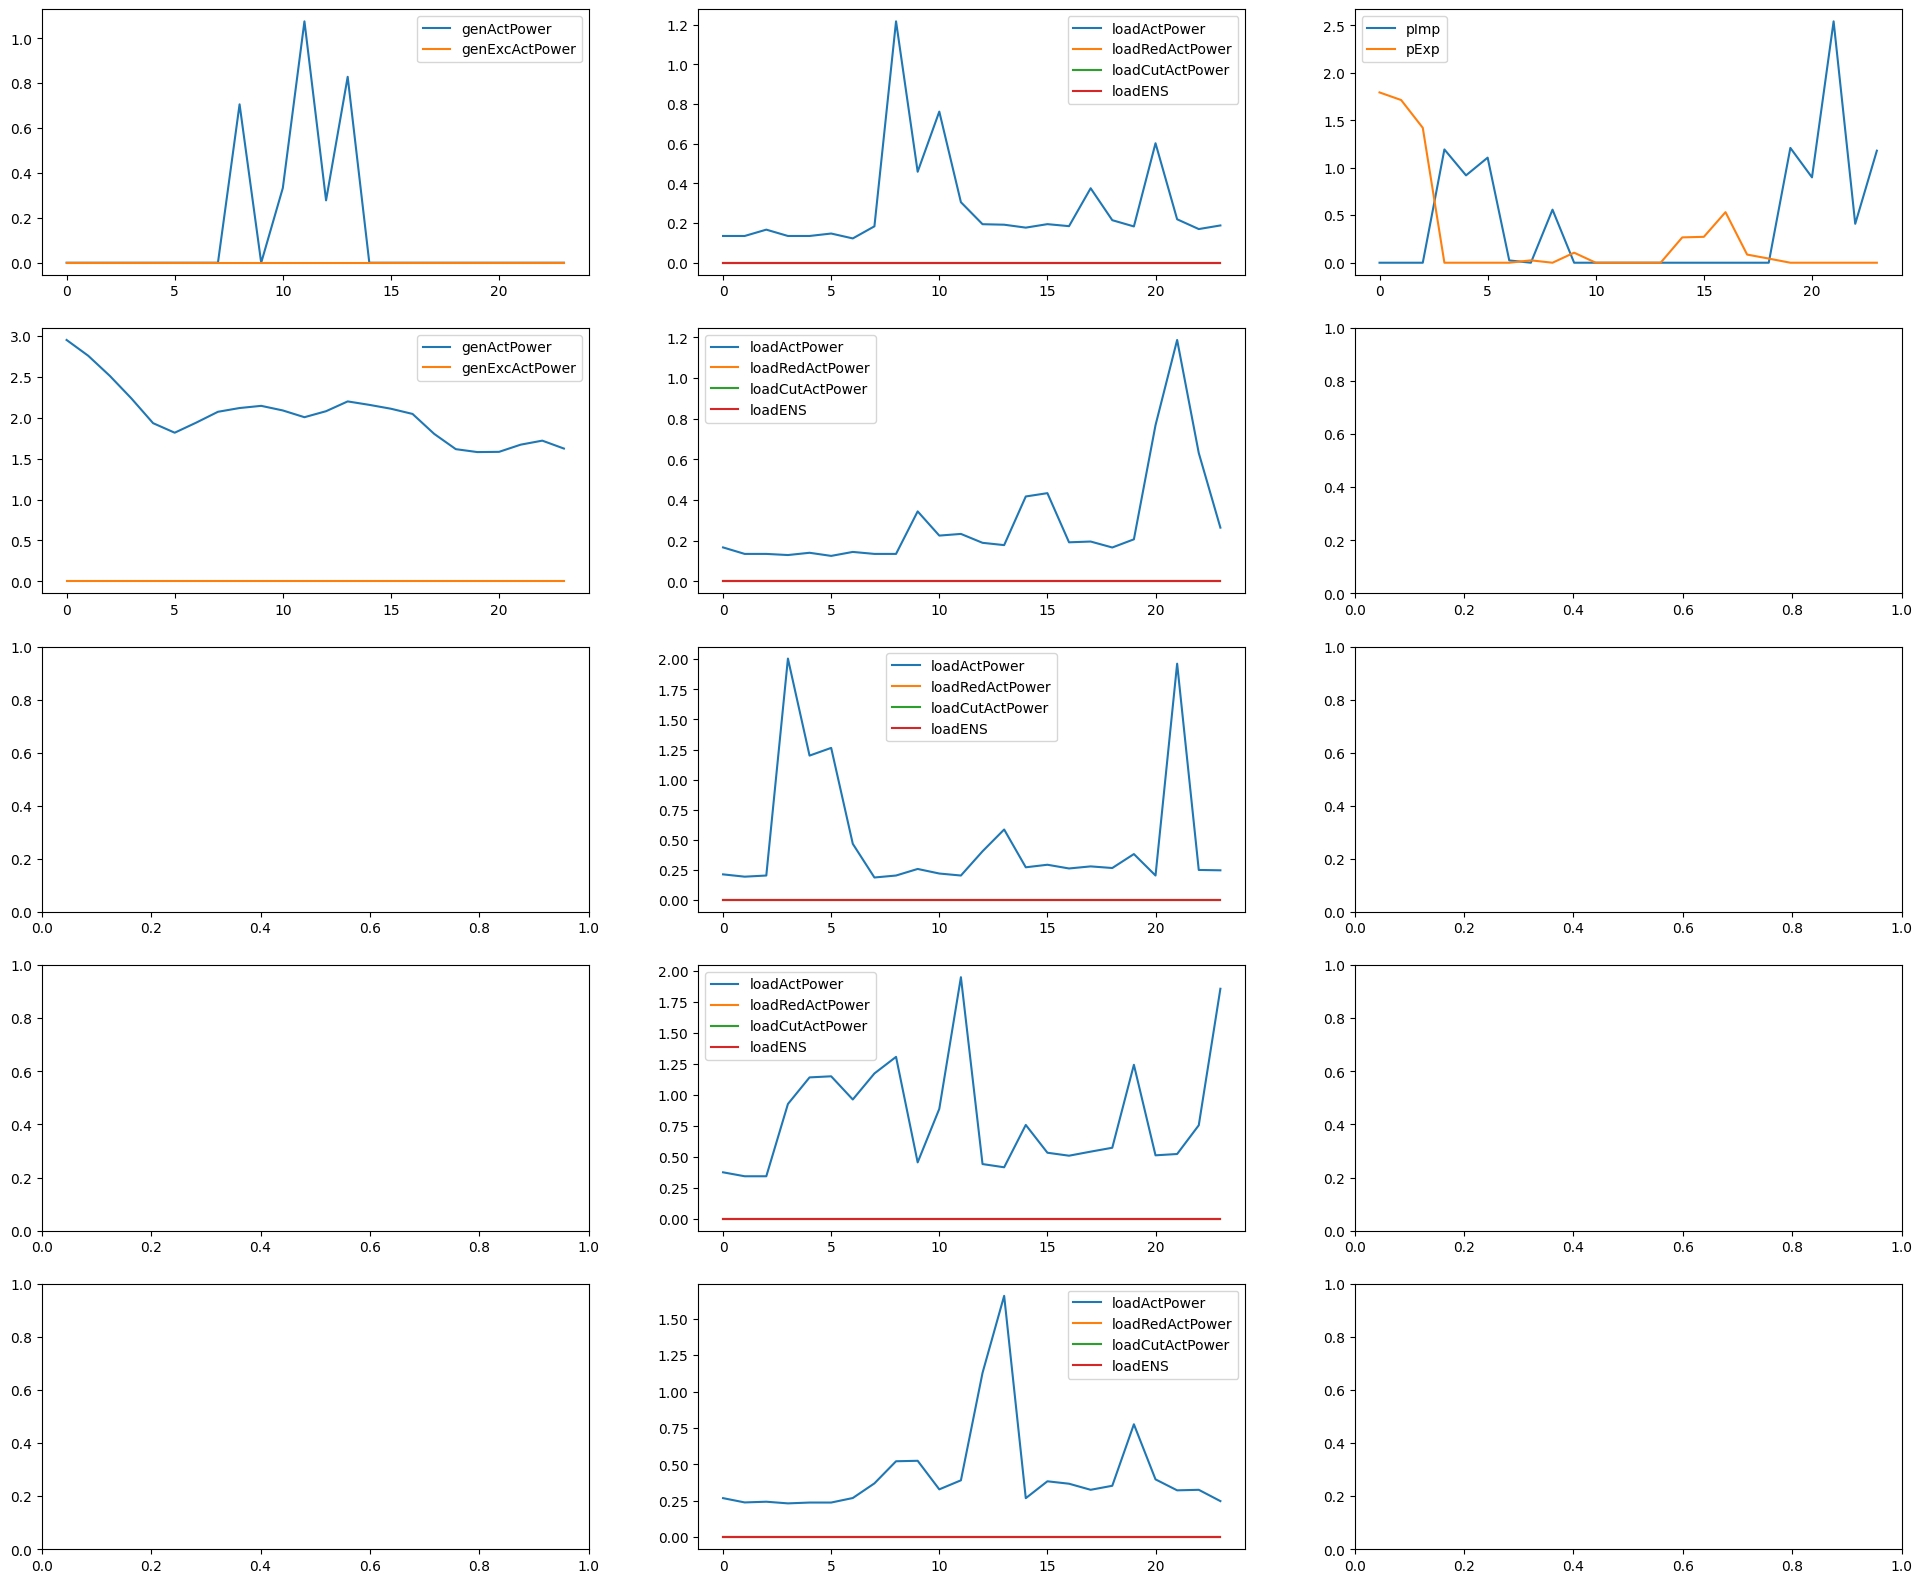

In [40]:
# Plot results

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(24, 20))

for i in np.arange(num_generators):
    # Generators
    axs[i, 0].plot(result_genActPower.values[i])
    axs[i, 0].plot(result_genExcActPower.values[i])
    axs[i, 0].legend(['genActPower', 'genExcActPower'])
    
for i in np.arange(5):
    # Loads
    axs[i, 1].plot(loadLimit[:, :, 0][i, :])
    axs[i, 1].plot(result_loadRedActPower.values[i])
    axs[i, 1].plot(result_loadCutActPower.values[i])
    axs[i, 1].plot(result_loadENS.values[i])
    axs[i, 1].legend(['loadActPower', 'loadRedActPower', 'loadCutActPower', 'loadENS'])


axs[0, 2].plot(result_pimp.values)
axs[0, 2].plot(result_pexp.values)
axs[0, 2].legend(['pImp', 'pExp'])


plt.show()

### Calculate total cost

In [41]:
print('Total import cost: {}'.format(sum(result_pimp.values.ravel() * buyPrice)))

Total import cost: 0.7503562721306207


In [90]:
# Used from PV
df = pd.read_csv('../results/cplex_pyomo/genActPower.csv', sep=',')
epv = df.mean(axis = 1).sum()*24
print(epv)

51.985565487104026


In [91]:
# Used from grid (imported)
df = pd.read_csv('../results/cplex_pyomo/pimp.csv', sep=',')
eg = df.mean(axis = 0).sum()*24
print(eg)

10.04350560710226


In [92]:
# Not used from PV (exported)
df = pd.read_csv('../results/cplex_pyomo/pexp.csv', sep=',')
ewpv = df.mean(axis = 0).sum()*24
print(ewpv)

6.260641140589206


In [93]:
# Total Production
print(pv_df.mean(axis = 0)['Production']/1000*24)

79.63560170021387


C:\Users\Nuno.Velosa.CORP\OneDrive - Unipartner IT Services, S.A\Desktop\eso_project\venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


In [94]:
# Not used from PV
print(abs(pv_df.loc[pv_df.Netload <= 0, 'Netload'].mean()) / 1000*24)

58.132587380141494


In [95]:
# Used from PV
print((abs(pv_df.loc[pv_df.Netload <= 0, 'Demand'].mean()/2) + abs(pv_df.loc[pv_df.Netload > 0, 'Production'].mean()/2)) / 1000*24)

45.68203007415758


In [96]:
# Used from grid
print(pv_df.loc[pv_df.Netload > 0, 'Netload'].mean() / 1000*24)

24.182025815526654
